# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
%matplotlib inline

import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import tensorflow as tf

data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

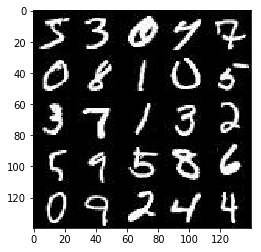

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

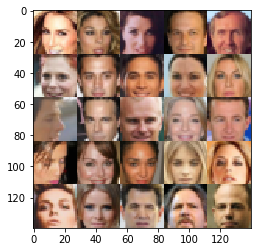

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [8]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    pl1 = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='Real_Input')
    pl2 = tf.placeholder(tf.float32, (None, z_dim), name='Z_Input')
    pl3 = tf.placeholder(tf.float32, name='Learning_Rate')

    return pl1, pl2, pl3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [9]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        l1 = tf.layers.conv2d(images, filters=64, kernel_size=(5,5), strides=(2,2), padding='same')
        l1 = tf.maximum(0.2*l1, l1)
        
        l2 = tf.layers.conv2d(l1, filters=128, kernel_size=(5,5), strides=(2,2), padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        l2 = tf.layers.batch_normalization(l2, training=True)
        l2 = tf.maximum(0.2*l2, l2)
        
        l3 = tf.layers.conv2d(l2, filters=256, kernel_size=(5,5), strides=(1,1), padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        l3 = tf.layers.batch_normalization(l3, training=True)
        l3 = tf.maximum(0.2*l3, l3)
        
        #l3 = tf.nn.dropout(l3, 0.6)
        
        l4 = tf.layers.conv2d(l3, filters=256, kernel_size=(5,5), strides=(1,1), padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        l4 = tf.layers.batch_normalization(l4, training=True)
        l4 = tf.maximum(0.2*l4, l4)
        
        flat = tf.reshape(l4, (-1,7*7*256))
        logits= tf.layers.dense(flat,1)
        out = tf.sigmoid(logits)
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [10]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        l1 = tf.layers.dense(z, 7*7*256)
        l1 = tf.reshape(l1, (-1,7,7,256))
        l1 = tf.layers.batch_normalization(l1, training=is_train)
        l1 = tf.maximum(0.2*l1,l1)
        
        l2 = tf.layers.conv2d_transpose(l1, 256, 5,strides=2, padding='same')
        l2 = tf.layers.batch_normalization(l2, training=is_train)
        l2 = tf.maximum(0.2*l2,l2)
        
        l3 = tf.layers.conv2d_transpose(l2, 128, 5,strides=2, padding='same')
        l3 = tf.layers.batch_normalization(l3, training=is_train)
        l3 = tf.maximum(0.2*l3,l3)
        
        #l3 = tf.nn.dropout(l3,0.6)
        
        l4 = tf.layers.conv2d_transpose(l3, 64, 5,strides=1, padding='same')
        l4 = tf.layers.batch_normalization(l4, training=is_train)
        l4 = tf.maximum(0.2*l4,l4)
        
        logits = tf.layers.conv2d_transpose(l4, out_channel_dim, 5, strides=1, padding='same')
        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [11]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    gen = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(gen, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    
    d_loss = d_loss_real+d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_v = tf.trainable_variables()
    d_v = [var for var in t_v if 'discriminator' in var.name]
    g_v = [var for var in t_v if 'generator' in var.name]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_v)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_v)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [14]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    steps=0;
    
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))

    samples, losses = [], []
    figsize=(5,5)
    #tf.reset_default_graph()

    input_real, input_z, learning_rate1 = model_inputs(data_shape[1], data_shape[2],data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_z = np.random.uniform(-1,1, size=(batch_size, z_dim))

                _ = sess.run(d_opt, feed_dict={input_real:batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z:batch_z,input_real:batch_images })
                
                steps = steps+1
                train_loss_d = d_loss.eval({input_z:batch_z, input_real:batch_images})
                train_loss_g = g_loss.eval({input_z:batch_z})
                if steps%10==0:
                    print("Epoch {}".format(epoch_i+1), "Discriminator Loss: {:.3f}".format(train_loss_d), "Generator Loss: {:.3f}".format(train_loss_g))
                
                if steps %100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1 Discriminator Loss: 0.031 Generator Loss: 4.393
Epoch 1 Discriminator Loss: 1.267 Generator Loss: 11.126
Epoch 1 Discriminator Loss: 1.050 Generator Loss: 0.871
Epoch 1 Discriminator Loss: 0.559 Generator Loss: 3.768
Epoch 1 Discriminator Loss: 0.528 Generator Loss: 1.548
Epoch 1 Discriminator Loss: 0.166 Generator Loss: 3.645
Epoch 1 Discriminator Loss: 0.379 Generator Loss: 2.800
Epoch 1 Discriminator Loss: 0.650 Generator Loss: 3.171
Epoch 1 Discriminator Loss: 0.578 Generator Loss: 2.628
Epoch 1 Discriminator Loss: 0.616 Generator Loss: 2.722


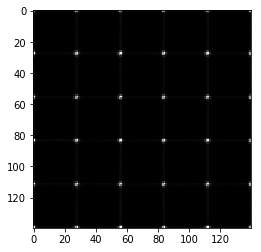

Epoch 1 Discriminator Loss: 0.516 Generator Loss: 1.688
Epoch 1 Discriminator Loss: 0.682 Generator Loss: 1.557
Epoch 1 Discriminator Loss: 0.199 Generator Loss: 2.688
Epoch 1 Discriminator Loss: 0.355 Generator Loss: 1.914
Epoch 1 Discriminator Loss: 0.079 Generator Loss: 3.396
Epoch 1 Discriminator Loss: 0.003 Generator Loss: 8.043
Epoch 1 Discriminator Loss: 0.621 Generator Loss: 1.404
Epoch 1 Discriminator Loss: 0.407 Generator Loss: 1.952
Epoch 1 Discriminator Loss: 0.183 Generator Loss: 2.568
Epoch 1 Discriminator Loss: 0.006 Generator Loss: 6.317


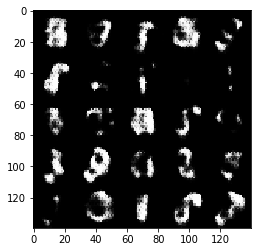

Epoch 1 Discriminator Loss: 0.036 Generator Loss: 3.942
Epoch 1 Discriminator Loss: 0.098 Generator Loss: 2.806
Epoch 1 Discriminator Loss: 0.068 Generator Loss: 3.174
Epoch 1 Discriminator Loss: 0.112 Generator Loss: 2.747
Epoch 1 Discriminator Loss: 7.042 Generator Loss: 0.024
Epoch 1 Discriminator Loss: 0.303 Generator Loss: 2.139
Epoch 1 Discriminator Loss: 0.245 Generator Loss: 2.582
Epoch 1 Discriminator Loss: 0.162 Generator Loss: 2.521
Epoch 1 Discriminator Loss: 2.026 Generator Loss: 12.305
Epoch 1 Discriminator Loss: 0.008 Generator Loss: 6.263


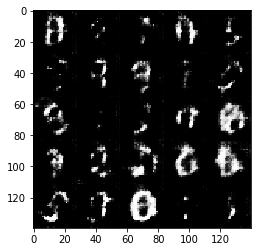

Epoch 1 Discriminator Loss: 0.036 Generator Loss: 3.890
Epoch 1 Discriminator Loss: 0.127 Generator Loss: 2.802
Epoch 1 Discriminator Loss: 0.002 Generator Loss: 10.790
Epoch 1 Discriminator Loss: 0.027 Generator Loss: 4.431
Epoch 1 Discriminator Loss: 17.566 Generator Loss: 16.926
Epoch 1 Discriminator Loss: 0.080 Generator Loss: 3.337
Epoch 1 Discriminator Loss: 0.842 Generator Loss: 0.989
Epoch 1 Discriminator Loss: 0.106 Generator Loss: 3.014
Epoch 1 Discriminator Loss: 0.278 Generator Loss: 3.802
Epoch 1 Discriminator Loss: 1.261 Generator Loss: 3.385


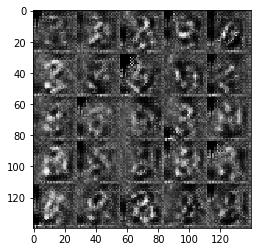

Epoch 1 Discriminator Loss: 0.731 Generator Loss: 1.308
Epoch 1 Discriminator Loss: 0.522 Generator Loss: 1.260
Epoch 1 Discriminator Loss: 0.048 Generator Loss: 7.036
Epoch 1 Discriminator Loss: 1.395 Generator Loss: 9.162
Epoch 1 Discriminator Loss: 0.373 Generator Loss: 1.758
Epoch 1 Discriminator Loss: 3.317 Generator Loss: 0.054
Epoch 1 Discriminator Loss: 1.033 Generator Loss: 1.268
Epoch 1 Discriminator Loss: 1.156 Generator Loss: 1.920
Epoch 1 Discriminator Loss: 0.774 Generator Loss: 0.902
Epoch 1 Discriminator Loss: 0.558 Generator Loss: 1.187


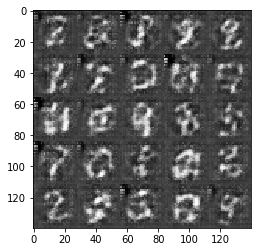

Epoch 1 Discriminator Loss: 0.500 Generator Loss: 2.490
Epoch 1 Discriminator Loss: 0.051 Generator Loss: 7.455
Epoch 1 Discriminator Loss: 1.760 Generator Loss: 0.378
Epoch 1 Discriminator Loss: 1.593 Generator Loss: 1.167
Epoch 1 Discriminator Loss: 1.102 Generator Loss: 0.725
Epoch 1 Discriminator Loss: 1.027 Generator Loss: 0.672
Epoch 1 Discriminator Loss: 1.091 Generator Loss: 0.824
Epoch 1 Discriminator Loss: 0.309 Generator Loss: 1.669
Epoch 1 Discriminator Loss: 0.086 Generator Loss: 3.702
Epoch 1 Discriminator Loss: 1.206 Generator Loss: 4.062


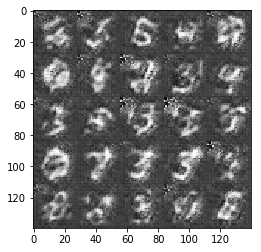

Epoch 1 Discriminator Loss: 0.517 Generator Loss: 2.727
Epoch 1 Discriminator Loss: 1.107 Generator Loss: 0.963
Epoch 1 Discriminator Loss: 0.319 Generator Loss: 2.601
Epoch 1 Discriminator Loss: 0.225 Generator Loss: 2.345
Epoch 1 Discriminator Loss: 0.616 Generator Loss: 1.820
Epoch 1 Discriminator Loss: 0.056 Generator Loss: 4.361
Epoch 1 Discriminator Loss: 0.074 Generator Loss: 4.008
Epoch 1 Discriminator Loss: 0.361 Generator Loss: 2.153
Epoch 1 Discriminator Loss: 1.055 Generator Loss: 1.547
Epoch 1 Discriminator Loss: 1.384 Generator Loss: 0.533


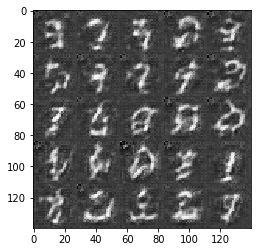

Epoch 1 Discriminator Loss: 0.561 Generator Loss: 1.736
Epoch 1 Discriminator Loss: 0.656 Generator Loss: 1.849
Epoch 1 Discriminator Loss: 0.411 Generator Loss: 1.898
Epoch 1 Discriminator Loss: 0.381 Generator Loss: 7.540
Epoch 1 Discriminator Loss: 0.089 Generator Loss: 4.816
Epoch 1 Discriminator Loss: 0.221 Generator Loss: 3.671
Epoch 1 Discriminator Loss: 1.614 Generator Loss: 7.222
Epoch 1 Discriminator Loss: 1.817 Generator Loss: 1.030
Epoch 1 Discriminator Loss: 0.798 Generator Loss: 1.294
Epoch 1 Discriminator Loss: 0.482 Generator Loss: 2.399


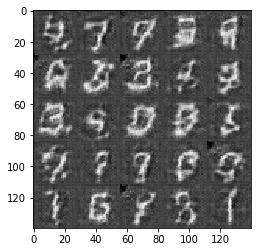

Epoch 1 Discriminator Loss: 0.641 Generator Loss: 1.751
Epoch 1 Discriminator Loss: 1.348 Generator Loss: 0.700
Epoch 1 Discriminator Loss: 0.240 Generator Loss: 2.278
Epoch 1 Discriminator Loss: 1.113 Generator Loss: 1.015
Epoch 1 Discriminator Loss: 1.829 Generator Loss: 6.152
Epoch 1 Discriminator Loss: 1.256 Generator Loss: 2.147
Epoch 1 Discriminator Loss: 0.690 Generator Loss: 2.603
Epoch 1 Discriminator Loss: 0.110 Generator Loss: 3.262
Epoch 1 Discriminator Loss: 0.564 Generator Loss: 1.565
Epoch 1 Discriminator Loss: 0.066 Generator Loss: 5.531


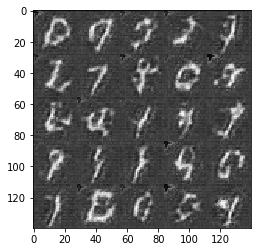

Epoch 1 Discriminator Loss: 0.013 Generator Loss: 6.577
Epoch 1 Discriminator Loss: 0.361 Generator Loss: 2.006
Epoch 1 Discriminator Loss: 0.034 Generator Loss: 4.036
Epoch 2 Discriminator Loss: 0.026 Generator Loss: 8.428
Epoch 2 Discriminator Loss: 0.323 Generator Loss: 2.289
Epoch 2 Discriminator Loss: 0.046 Generator Loss: 3.670
Epoch 2 Discriminator Loss: 0.259 Generator Loss: 2.142
Epoch 2 Discriminator Loss: 0.012 Generator Loss: 5.882
Epoch 2 Discriminator Loss: 0.013 Generator Loss: 10.817
Epoch 2 Discriminator Loss: 0.534 Generator Loss: 3.198


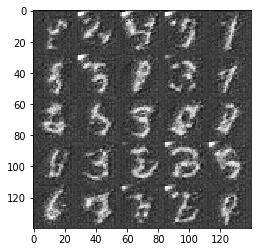

Epoch 2 Discriminator Loss: 1.331 Generator Loss: 0.887
Epoch 2 Discriminator Loss: 0.358 Generator Loss: 2.761
Epoch 2 Discriminator Loss: 0.302 Generator Loss: 2.480
Epoch 2 Discriminator Loss: 2.929 Generator Loss: 7.499
Epoch 2 Discriminator Loss: 0.277 Generator Loss: 3.401
Epoch 2 Discriminator Loss: 0.465 Generator Loss: 3.197
Epoch 2 Discriminator Loss: 1.728 Generator Loss: 0.534
Epoch 2 Discriminator Loss: 0.995 Generator Loss: 0.782
Epoch 2 Discriminator Loss: 0.489 Generator Loss: 2.114
Epoch 2 Discriminator Loss: 0.085 Generator Loss: 5.152


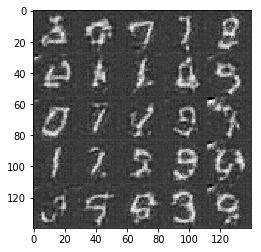

Epoch 2 Discriminator Loss: 0.189 Generator Loss: 3.147
Epoch 2 Discriminator Loss: 2.805 Generator Loss: 0.339
Epoch 2 Discriminator Loss: 0.876 Generator Loss: 1.952
Epoch 2 Discriminator Loss: 0.675 Generator Loss: 2.215
Epoch 2 Discriminator Loss: 0.443 Generator Loss: 2.621
Epoch 2 Discriminator Loss: 0.187 Generator Loss: 4.850
Epoch 2 Discriminator Loss: 0.048 Generator Loss: 5.286
Epoch 2 Discriminator Loss: 0.375 Generator Loss: 5.011
Epoch 2 Discriminator Loss: 3.327 Generator Loss: 0.256
Epoch 2 Discriminator Loss: 0.867 Generator Loss: 1.134


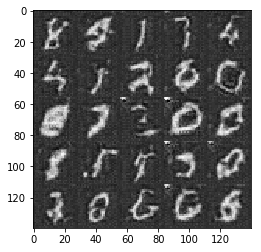

Epoch 2 Discriminator Loss: 0.632 Generator Loss: 1.873
Epoch 2 Discriminator Loss: 0.535 Generator Loss: 2.661
Epoch 2 Discriminator Loss: 0.466 Generator Loss: 4.048
Epoch 2 Discriminator Loss: 0.241 Generator Loss: 2.703
Epoch 2 Discriminator Loss: 0.061 Generator Loss: 3.984
Epoch 2 Discriminator Loss: 0.030 Generator Loss: 5.036
Epoch 2 Discriminator Loss: 0.035 Generator Loss: 5.838
Epoch 2 Discriminator Loss: 0.023 Generator Loss: 6.745
Epoch 2 Discriminator Loss: 0.007 Generator Loss: 10.046
Epoch 2 Discriminator Loss: 1.514 Generator Loss: 1.400


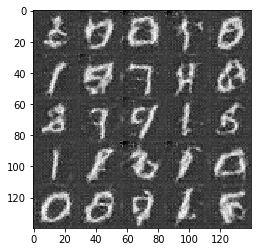

Epoch 2 Discriminator Loss: 0.714 Generator Loss: 1.914
Epoch 2 Discriminator Loss: 1.334 Generator Loss: 2.285
Epoch 2 Discriminator Loss: 1.497 Generator Loss: 0.481
Epoch 2 Discriminator Loss: 1.195 Generator Loss: 0.600
Epoch 2 Discriminator Loss: 2.678 Generator Loss: 0.144
Epoch 2 Discriminator Loss: 0.829 Generator Loss: 1.208
Epoch 2 Discriminator Loss: 1.224 Generator Loss: 4.057
Epoch 2 Discriminator Loss: 0.904 Generator Loss: 0.759
Epoch 2 Discriminator Loss: 0.225 Generator Loss: 4.672
Epoch 2 Discriminator Loss: 3.635 Generator Loss: 5.309


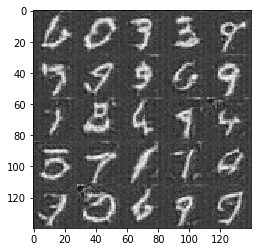

Epoch 2 Discriminator Loss: 0.442 Generator Loss: 1.701
Epoch 2 Discriminator Loss: 0.080 Generator Loss: 4.142
Epoch 2 Discriminator Loss: 0.722 Generator Loss: 1.821
Epoch 2 Discriminator Loss: 0.700 Generator Loss: 1.293
Epoch 2 Discriminator Loss: 0.528 Generator Loss: 1.644
Epoch 2 Discriminator Loss: 0.265 Generator Loss: 2.308
Epoch 2 Discriminator Loss: 0.363 Generator Loss: 2.252
Epoch 2 Discriminator Loss: 0.342 Generator Loss: 1.955
Epoch 2 Discriminator Loss: 0.402 Generator Loss: 1.739
Epoch 2 Discriminator Loss: 1.121 Generator Loss: 1.057


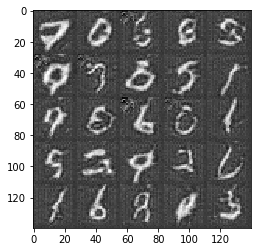

Epoch 2 Discriminator Loss: 0.782 Generator Loss: 1.191
Epoch 2 Discriminator Loss: 0.795 Generator Loss: 1.228
Epoch 2 Discriminator Loss: 0.219 Generator Loss: 3.563
Epoch 2 Discriminator Loss: 0.354 Generator Loss: 4.182
Epoch 2 Discriminator Loss: 0.190 Generator Loss: 3.244
Epoch 2 Discriminator Loss: 2.671 Generator Loss: 10.294
Epoch 2 Discriminator Loss: 0.455 Generator Loss: 2.069
Epoch 2 Discriminator Loss: 1.311 Generator Loss: 2.418
Epoch 2 Discriminator Loss: 0.919 Generator Loss: 1.512
Epoch 2 Discriminator Loss: 0.096 Generator Loss: 4.157


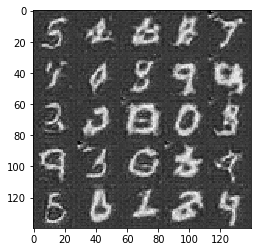

Epoch 2 Discriminator Loss: 0.821 Generator Loss: 1.179
Epoch 2 Discriminator Loss: 0.601 Generator Loss: 2.041
Epoch 2 Discriminator Loss: 0.125 Generator Loss: 3.112
Epoch 2 Discriminator Loss: 0.154 Generator Loss: 6.041
Epoch 2 Discriminator Loss: 1.361 Generator Loss: 4.113
Epoch 2 Discriminator Loss: 1.417 Generator Loss: 0.613
Epoch 2 Discriminator Loss: 0.255 Generator Loss: 3.170
Epoch 2 Discriminator Loss: 0.062 Generator Loss: 4.091
Epoch 2 Discriminator Loss: 0.771 Generator Loss: 0.939
Epoch 2 Discriminator Loss: 0.303 Generator Loss: 2.355


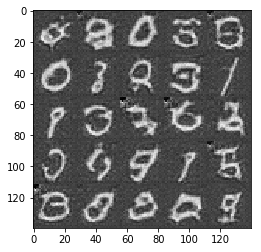

Epoch 2 Discriminator Loss: 0.255 Generator Loss: 8.084
Epoch 2 Discriminator Loss: 0.010 Generator Loss: 7.322
Epoch 2 Discriminator Loss: 2.346 Generator Loss: 0.245
Epoch 2 Discriminator Loss: 3.930 Generator Loss: 7.276
Epoch 2 Discriminator Loss: 0.547 Generator Loss: 1.938
Epoch 2 Discriminator Loss: 0.813 Generator Loss: 1.814
Epoch 2 Discriminator Loss: 0.756 Generator Loss: 1.500
Epoch 2 Discriminator Loss: 0.640 Generator Loss: 3.933
Epoch 2 Discriminator Loss: 0.114 Generator Loss: 4.991
Epoch 2 Discriminator Loss: 1.552 Generator Loss: 0.434


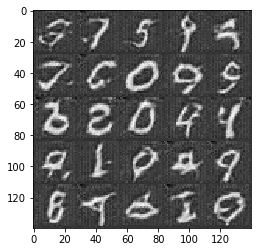

Epoch 2 Discriminator Loss: 1.079 Generator Loss: 0.819
Epoch 2 Discriminator Loss: 0.598 Generator Loss: 3.027
Epoch 2 Discriminator Loss: 0.791 Generator Loss: 0.990
Epoch 2 Discriminator Loss: 0.705 Generator Loss: 1.153
Epoch 2 Discriminator Loss: 1.003 Generator Loss: 1.907
Epoch 2 Discriminator Loss: 1.142 Generator Loss: 7.269
Epoch 2 Discriminator Loss: 0.203 Generator Loss: 2.927


In [15]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1 Discriminator Loss: 0.196 Generator Loss: 30.563
Epoch 1 Discriminator Loss: 3.560 Generator Loss: 0.472
Epoch 1 Discriminator Loss: 4.173 Generator Loss: 0.688
Epoch 1 Discriminator Loss: 0.761 Generator Loss: 1.976
Epoch 1 Discriminator Loss: 1.281 Generator Loss: 0.775
Epoch 1 Discriminator Loss: 0.392 Generator Loss: 3.925
Epoch 1 Discriminator Loss: 0.189 Generator Loss: 3.094
Epoch 1 Discriminator Loss: 6.910 Generator Loss: 17.867
Epoch 1 Discriminator Loss: 0.304 Generator Loss: 2.102
Epoch 1 Discriminator Loss: 0.149 Generator Loss: 3.181


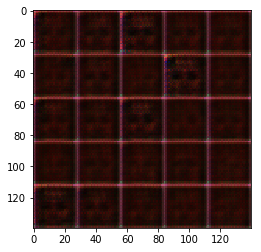

Epoch 1 Discriminator Loss: 0.039 Generator Loss: 4.668
Epoch 1 Discriminator Loss: 0.407 Generator Loss: 1.612
Epoch 1 Discriminator Loss: 0.822 Generator Loss: 2.269
Epoch 1 Discriminator Loss: 0.540 Generator Loss: 2.527
Epoch 1 Discriminator Loss: 5.829 Generator Loss: 7.972
Epoch 1 Discriminator Loss: 0.526 Generator Loss: 1.348
Epoch 1 Discriminator Loss: 0.196 Generator Loss: 2.734
Epoch 1 Discriminator Loss: 0.306 Generator Loss: 4.574
Epoch 1 Discriminator Loss: 0.075 Generator Loss: 3.600
Epoch 1 Discriminator Loss: 1.489 Generator Loss: 0.356


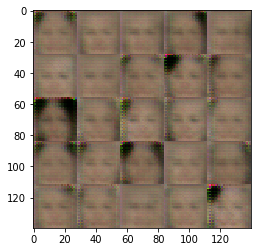

Epoch 1 Discriminator Loss: 0.718 Generator Loss: 3.122
Epoch 1 Discriminator Loss: 0.396 Generator Loss: 1.616
Epoch 1 Discriminator Loss: 0.357 Generator Loss: 3.132
Epoch 1 Discriminator Loss: 0.697 Generator Loss: 2.327
Epoch 1 Discriminator Loss: 1.134 Generator Loss: 1.062
Epoch 1 Discriminator Loss: 0.915 Generator Loss: 0.939
Epoch 1 Discriminator Loss: 0.283 Generator Loss: 2.630
Epoch 1 Discriminator Loss: 0.164 Generator Loss: 2.778
Epoch 1 Discriminator Loss: 4.241 Generator Loss: 6.847
Epoch 1 Discriminator Loss: 0.842 Generator Loss: 0.667


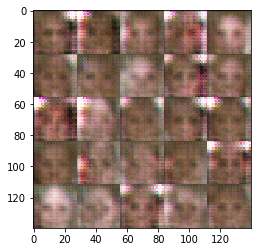

Epoch 1 Discriminator Loss: 0.358 Generator Loss: 1.599
Epoch 1 Discriminator Loss: 0.062 Generator Loss: 4.728
Epoch 1 Discriminator Loss: 1.435 Generator Loss: 0.434
Epoch 1 Discriminator Loss: 0.319 Generator Loss: 1.660
Epoch 1 Discriminator Loss: 0.035 Generator Loss: 4.052
Epoch 1 Discriminator Loss: 0.688 Generator Loss: 0.992
Epoch 1 Discriminator Loss: 0.167 Generator Loss: 2.130
Epoch 1 Discriminator Loss: 0.038 Generator Loss: 3.774
Epoch 1 Discriminator Loss: 0.121 Generator Loss: 2.881
Epoch 1 Discriminator Loss: 0.693 Generator Loss: 1.637


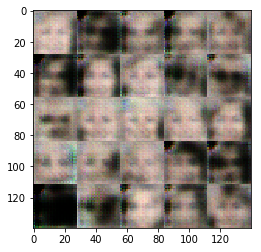

Epoch 1 Discriminator Loss: 0.858 Generator Loss: 1.613
Epoch 1 Discriminator Loss: 0.273 Generator Loss: 3.185
Epoch 1 Discriminator Loss: 3.662 Generator Loss: 0.054
Epoch 1 Discriminator Loss: 0.229 Generator Loss: 1.823
Epoch 1 Discriminator Loss: 0.151 Generator Loss: 3.254
Epoch 1 Discriminator Loss: 0.083 Generator Loss: 3.280
Epoch 1 Discriminator Loss: 0.163 Generator Loss: 2.794
Epoch 1 Discriminator Loss: 0.184 Generator Loss: 3.073
Epoch 1 Discriminator Loss: 0.187 Generator Loss: 2.635
Epoch 1 Discriminator Loss: 0.619 Generator Loss: 1.573


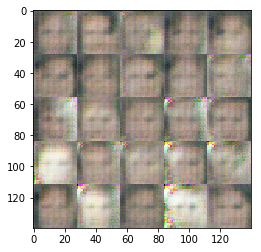

Epoch 1 Discriminator Loss: 0.085 Generator Loss: 2.973
Epoch 1 Discriminator Loss: 0.694 Generator Loss: 1.832
Epoch 1 Discriminator Loss: 0.085 Generator Loss: 2.726
Epoch 1 Discriminator Loss: 0.055 Generator Loss: 3.446
Epoch 1 Discriminator Loss: 0.424 Generator Loss: 1.607
Epoch 1 Discriminator Loss: 0.374 Generator Loss: 2.342
Epoch 1 Discriminator Loss: 2.002 Generator Loss: 0.600
Epoch 1 Discriminator Loss: 1.443 Generator Loss: 0.732
Epoch 1 Discriminator Loss: 1.276 Generator Loss: 0.752
Epoch 1 Discriminator Loss: 1.360 Generator Loss: 0.618


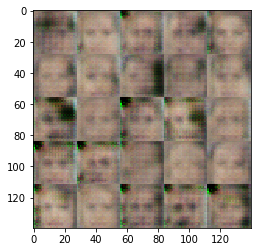

Epoch 1 Discriminator Loss: 1.318 Generator Loss: 0.685
Epoch 1 Discriminator Loss: 1.471 Generator Loss: 0.645
Epoch 1 Discriminator Loss: 1.247 Generator Loss: 1.035
Epoch 1 Discriminator Loss: 1.426 Generator Loss: 1.137
Epoch 1 Discriminator Loss: 1.324 Generator Loss: 1.012
Epoch 1 Discriminator Loss: 1.284 Generator Loss: 0.930
Epoch 1 Discriminator Loss: 1.231 Generator Loss: 0.882
Epoch 1 Discriminator Loss: 1.169 Generator Loss: 0.739
Epoch 1 Discriminator Loss: 1.382 Generator Loss: 1.156
Epoch 1 Discriminator Loss: 1.199 Generator Loss: 0.723


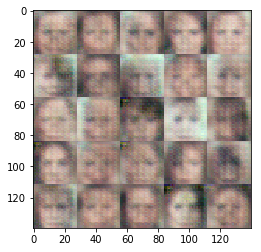

Epoch 1 Discriminator Loss: 1.271 Generator Loss: 1.287
Epoch 1 Discriminator Loss: 1.391 Generator Loss: 0.676
Epoch 1 Discriminator Loss: 0.413 Generator Loss: 2.067
Epoch 1 Discriminator Loss: 0.605 Generator Loss: 1.005
Epoch 1 Discriminator Loss: 0.442 Generator Loss: 1.452
Epoch 1 Discriminator Loss: 0.167 Generator Loss: 2.957
Epoch 1 Discriminator Loss: 0.285 Generator Loss: 2.983
Epoch 1 Discriminator Loss: 0.128 Generator Loss: 4.366
Epoch 1 Discriminator Loss: 0.105 Generator Loss: 2.867
Epoch 1 Discriminator Loss: 0.067 Generator Loss: 2.983


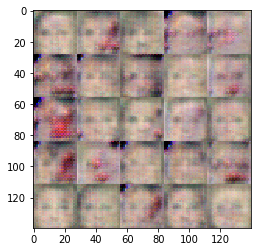

Epoch 1 Discriminator Loss: 1.573 Generator Loss: 2.013
Epoch 1 Discriminator Loss: 0.962 Generator Loss: 1.094
Epoch 1 Discriminator Loss: 1.869 Generator Loss: 1.488
Epoch 1 Discriminator Loss: 0.903 Generator Loss: 1.153
Epoch 1 Discriminator Loss: 1.069 Generator Loss: 0.880
Epoch 1 Discriminator Loss: 1.694 Generator Loss: 0.714
Epoch 1 Discriminator Loss: 1.224 Generator Loss: 0.783
Epoch 1 Discriminator Loss: 0.215 Generator Loss: 2.548
Epoch 1 Discriminator Loss: 0.450 Generator Loss: 2.885
Epoch 1 Discriminator Loss: 2.558 Generator Loss: 4.147


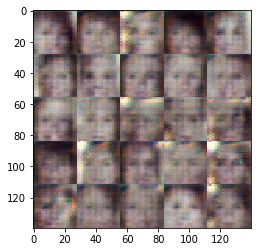

Epoch 1 Discriminator Loss: 0.124 Generator Loss: 2.598
Epoch 1 Discriminator Loss: 0.486 Generator Loss: 4.538
Epoch 1 Discriminator Loss: 1.091 Generator Loss: 4.356
Epoch 1 Discriminator Loss: 2.025 Generator Loss: 0.614
Epoch 1 Discriminator Loss: 1.460 Generator Loss: 0.979
Epoch 1 Discriminator Loss: 1.506 Generator Loss: 1.012
Epoch 1 Discriminator Loss: 1.359 Generator Loss: 0.711
Epoch 1 Discriminator Loss: 1.426 Generator Loss: 0.687
Epoch 1 Discriminator Loss: 1.423 Generator Loss: 0.736
Epoch 1 Discriminator Loss: 1.415 Generator Loss: 0.625


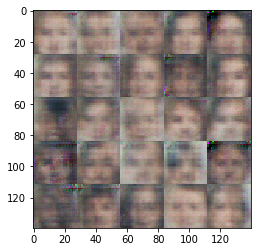

Epoch 1 Discriminator Loss: 1.393 Generator Loss: 1.060
Epoch 1 Discriminator Loss: 1.407 Generator Loss: 0.618
Epoch 1 Discriminator Loss: 1.374 Generator Loss: 0.842
Epoch 1 Discriminator Loss: 1.398 Generator Loss: 0.888
Epoch 1 Discriminator Loss: 1.249 Generator Loss: 0.722
Epoch 1 Discriminator Loss: 1.284 Generator Loss: 0.873
Epoch 1 Discriminator Loss: 1.313 Generator Loss: 0.752
Epoch 1 Discriminator Loss: 1.248 Generator Loss: 0.720
Epoch 1 Discriminator Loss: 1.493 Generator Loss: 0.641
Epoch 1 Discriminator Loss: 1.355 Generator Loss: 0.819


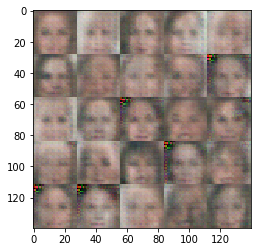

Epoch 1 Discriminator Loss: 1.359 Generator Loss: 0.640
Epoch 1 Discriminator Loss: 1.301 Generator Loss: 0.892
Epoch 1 Discriminator Loss: 1.497 Generator Loss: 0.992
Epoch 1 Discriminator Loss: 1.365 Generator Loss: 1.021
Epoch 1 Discriminator Loss: 1.305 Generator Loss: 1.133
Epoch 1 Discriminator Loss: 1.316 Generator Loss: 0.897
Epoch 1 Discriminator Loss: 1.498 Generator Loss: 0.630
Epoch 1 Discriminator Loss: 1.389 Generator Loss: 0.716
Epoch 1 Discriminator Loss: 1.359 Generator Loss: 0.885
Epoch 1 Discriminator Loss: 1.364 Generator Loss: 0.848


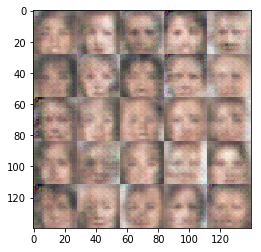

Epoch 1 Discriminator Loss: 1.305 Generator Loss: 0.641
Epoch 1 Discriminator Loss: 1.410 Generator Loss: 0.815
Epoch 1 Discriminator Loss: 1.366 Generator Loss: 0.837
Epoch 1 Discriminator Loss: 1.290 Generator Loss: 0.688
Epoch 1 Discriminator Loss: 1.348 Generator Loss: 0.926
Epoch 1 Discriminator Loss: 1.358 Generator Loss: 0.746
Epoch 1 Discriminator Loss: 1.376 Generator Loss: 0.769
Epoch 1 Discriminator Loss: 1.248 Generator Loss: 0.749
Epoch 1 Discriminator Loss: 1.402 Generator Loss: 0.759
Epoch 1 Discriminator Loss: 1.456 Generator Loss: 0.545


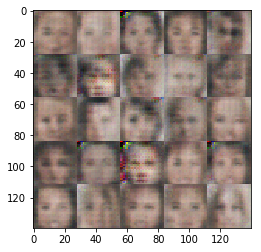

Epoch 1 Discriminator Loss: 1.240 Generator Loss: 0.832
Epoch 1 Discriminator Loss: 1.238 Generator Loss: 0.732
Epoch 1 Discriminator Loss: 1.386 Generator Loss: 0.734
Epoch 1 Discriminator Loss: 1.485 Generator Loss: 0.989
Epoch 1 Discriminator Loss: 1.347 Generator Loss: 0.717
Epoch 1 Discriminator Loss: 1.351 Generator Loss: 0.867
Epoch 1 Discriminator Loss: 1.397 Generator Loss: 0.570
Epoch 1 Discriminator Loss: 1.371 Generator Loss: 0.640
Epoch 1 Discriminator Loss: 1.283 Generator Loss: 0.882
Epoch 1 Discriminator Loss: 1.361 Generator Loss: 0.671


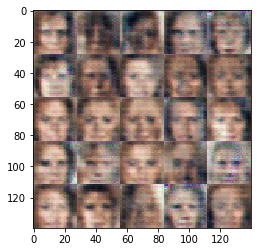

Epoch 1 Discriminator Loss: 1.277 Generator Loss: 0.699
Epoch 1 Discriminator Loss: 1.528 Generator Loss: 0.666
Epoch 1 Discriminator Loss: 1.296 Generator Loss: 0.711
Epoch 1 Discriminator Loss: 1.285 Generator Loss: 0.763
Epoch 1 Discriminator Loss: 1.351 Generator Loss: 0.694
Epoch 1 Discriminator Loss: 1.341 Generator Loss: 0.815
Epoch 1 Discriminator Loss: 1.417 Generator Loss: 0.934
Epoch 1 Discriminator Loss: 1.431 Generator Loss: 0.759
Epoch 1 Discriminator Loss: 1.451 Generator Loss: 0.573
Epoch 1 Discriminator Loss: 1.584 Generator Loss: 0.806


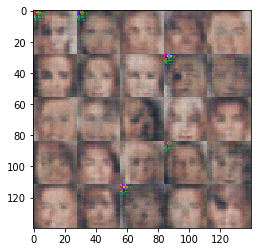

Epoch 1 Discriminator Loss: 1.266 Generator Loss: 0.677
Epoch 1 Discriminator Loss: 1.292 Generator Loss: 0.664
Epoch 1 Discriminator Loss: 1.455 Generator Loss: 0.737
Epoch 1 Discriminator Loss: 1.336 Generator Loss: 0.756
Epoch 1 Discriminator Loss: 1.232 Generator Loss: 0.952
Epoch 1 Discriminator Loss: 1.340 Generator Loss: 0.702
Epoch 1 Discriminator Loss: 1.269 Generator Loss: 0.817
Epoch 1 Discriminator Loss: 1.332 Generator Loss: 0.790
Epoch 1 Discriminator Loss: 1.441 Generator Loss: 0.797
Epoch 1 Discriminator Loss: 1.470 Generator Loss: 0.933


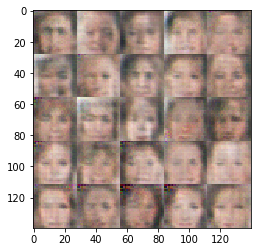

Epoch 1 Discriminator Loss: 1.363 Generator Loss: 0.700
Epoch 1 Discriminator Loss: 1.499 Generator Loss: 0.616
Epoch 1 Discriminator Loss: 1.545 Generator Loss: 0.922
Epoch 1 Discriminator Loss: 1.240 Generator Loss: 0.804
Epoch 1 Discriminator Loss: 1.331 Generator Loss: 0.563
Epoch 1 Discriminator Loss: 1.377 Generator Loss: 0.838
Epoch 1 Discriminator Loss: 1.237 Generator Loss: 0.792
Epoch 1 Discriminator Loss: 1.260 Generator Loss: 0.699
Epoch 1 Discriminator Loss: 1.197 Generator Loss: 0.818
Epoch 1 Discriminator Loss: 1.484 Generator Loss: 0.937


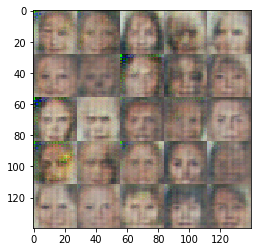

Epoch 1 Discriminator Loss: 1.403 Generator Loss: 0.771
Epoch 1 Discriminator Loss: 1.433 Generator Loss: 0.488
Epoch 1 Discriminator Loss: 1.269 Generator Loss: 0.774
Epoch 1 Discriminator Loss: 1.239 Generator Loss: 0.964
Epoch 1 Discriminator Loss: 1.409 Generator Loss: 0.947
Epoch 1 Discriminator Loss: 1.344 Generator Loss: 0.663
Epoch 1 Discriminator Loss: 1.700 Generator Loss: 0.375
Epoch 1 Discriminator Loss: 1.397 Generator Loss: 0.672
Epoch 1 Discriminator Loss: 1.476 Generator Loss: 0.681
Epoch 1 Discriminator Loss: 1.536 Generator Loss: 0.671


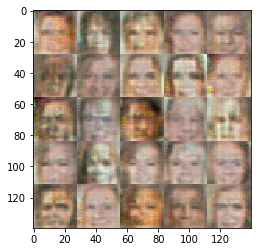

Epoch 1 Discriminator Loss: 1.323 Generator Loss: 0.929
Epoch 1 Discriminator Loss: 1.420 Generator Loss: 0.608
Epoch 1 Discriminator Loss: 1.574 Generator Loss: 0.488
Epoch 1 Discriminator Loss: 1.245 Generator Loss: 0.675
Epoch 1 Discriminator Loss: 1.542 Generator Loss: 0.845
Epoch 1 Discriminator Loss: 1.254 Generator Loss: 0.705
Epoch 1 Discriminator Loss: 1.455 Generator Loss: 0.813
Epoch 1 Discriminator Loss: 1.514 Generator Loss: 0.588
Epoch 1 Discriminator Loss: 1.135 Generator Loss: 0.744
Epoch 1 Discriminator Loss: 1.462 Generator Loss: 0.707


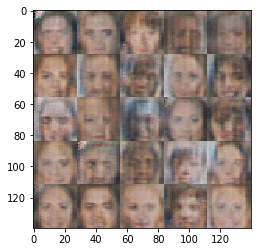

Epoch 1 Discriminator Loss: 1.504 Generator Loss: 1.045
Epoch 1 Discriminator Loss: 1.308 Generator Loss: 0.741
Epoch 1 Discriminator Loss: 1.309 Generator Loss: 0.771
Epoch 1 Discriminator Loss: 1.371 Generator Loss: 0.889
Epoch 1 Discriminator Loss: 1.344 Generator Loss: 0.688
Epoch 1 Discriminator Loss: 1.232 Generator Loss: 0.881
Epoch 1 Discriminator Loss: 1.543 Generator Loss: 0.693
Epoch 1 Discriminator Loss: 1.370 Generator Loss: 0.592
Epoch 1 Discriminator Loss: 1.367 Generator Loss: 0.674
Epoch 1 Discriminator Loss: 1.576 Generator Loss: 1.310


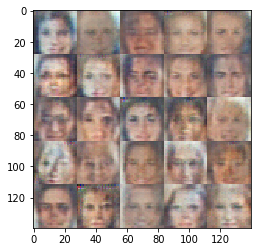

Epoch 1 Discriminator Loss: 1.372 Generator Loss: 0.678
Epoch 1 Discriminator Loss: 1.399 Generator Loss: 0.648
Epoch 1 Discriminator Loss: 1.514 Generator Loss: 0.611
Epoch 1 Discriminator Loss: 1.337 Generator Loss: 0.826
Epoch 1 Discriminator Loss: 1.409 Generator Loss: 0.704
Epoch 1 Discriminator Loss: 1.422 Generator Loss: 0.859
Epoch 1 Discriminator Loss: 1.257 Generator Loss: 0.537
Epoch 1 Discriminator Loss: 0.735 Generator Loss: 1.555
Epoch 1 Discriminator Loss: 1.251 Generator Loss: 0.532
Epoch 1 Discriminator Loss: 1.573 Generator Loss: 2.426


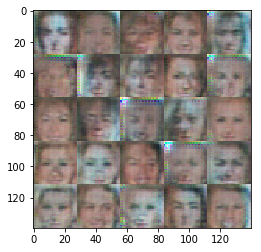

Epoch 1 Discriminator Loss: 0.327 Generator Loss: 2.092
Epoch 1 Discriminator Loss: 1.314 Generator Loss: 1.019
Epoch 1 Discriminator Loss: 3.415 Generator Loss: 1.873
Epoch 1 Discriminator Loss: 1.075 Generator Loss: 0.829
Epoch 1 Discriminator Loss: 1.399 Generator Loss: 0.633
Epoch 1 Discriminator Loss: 1.386 Generator Loss: 1.174
Epoch 1 Discriminator Loss: 1.398 Generator Loss: 0.842
Epoch 1 Discriminator Loss: 1.115 Generator Loss: 1.217
Epoch 1 Discriminator Loss: 1.018 Generator Loss: 3.566
Epoch 1 Discriminator Loss: 0.579 Generator Loss: 1.595


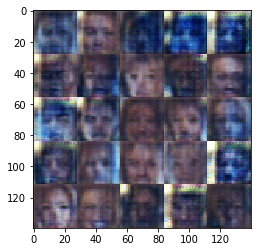

Epoch 1 Discriminator Loss: 0.912 Generator Loss: 3.746
Epoch 1 Discriminator Loss: 0.227 Generator Loss: 2.161
Epoch 1 Discriminator Loss: 4.183 Generator Loss: 0.031
Epoch 1 Discriminator Loss: 1.509 Generator Loss: 1.227
Epoch 1 Discriminator Loss: 1.567 Generator Loss: 0.678
Epoch 1 Discriminator Loss: 1.395 Generator Loss: 0.929
Epoch 1 Discriminator Loss: 1.211 Generator Loss: 0.785
Epoch 1 Discriminator Loss: 1.454 Generator Loss: 0.754
Epoch 1 Discriminator Loss: 1.490 Generator Loss: 0.978
Epoch 1 Discriminator Loss: 1.412 Generator Loss: 0.889


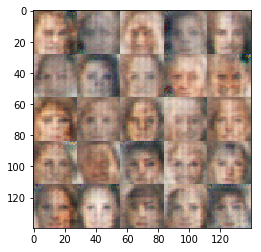

Epoch 1 Discriminator Loss: 1.295 Generator Loss: 0.875
Epoch 1 Discriminator Loss: 1.422 Generator Loss: 0.794
Epoch 1 Discriminator Loss: 1.349 Generator Loss: 0.716
Epoch 1 Discriminator Loss: 1.436 Generator Loss: 0.695
Epoch 1 Discriminator Loss: 1.335 Generator Loss: 0.855
Epoch 1 Discriminator Loss: 1.412 Generator Loss: 0.732
Epoch 1 Discriminator Loss: 1.438 Generator Loss: 0.816
Epoch 1 Discriminator Loss: 1.426 Generator Loss: 0.947
Epoch 1 Discriminator Loss: 1.387 Generator Loss: 0.700
Epoch 1 Discriminator Loss: 1.408 Generator Loss: 0.761


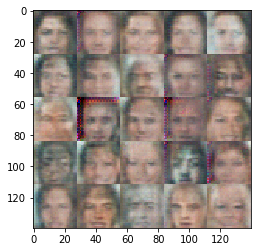

Epoch 1 Discriminator Loss: 1.339 Generator Loss: 0.703
Epoch 1 Discriminator Loss: 1.359 Generator Loss: 0.698
Epoch 1 Discriminator Loss: 1.452 Generator Loss: 0.797
Epoch 1 Discriminator Loss: 1.386 Generator Loss: 0.584
Epoch 1 Discriminator Loss: 1.387 Generator Loss: 0.733
Epoch 1 Discriminator Loss: 1.302 Generator Loss: 0.593
Epoch 1 Discriminator Loss: 1.346 Generator Loss: 0.701
Epoch 1 Discriminator Loss: 1.447 Generator Loss: 1.023
Epoch 1 Discriminator Loss: 1.413 Generator Loss: 0.643
Epoch 1 Discriminator Loss: 1.368 Generator Loss: 0.715


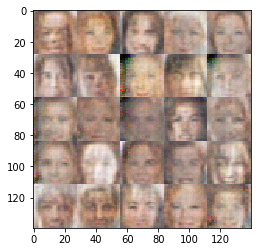

Epoch 1 Discriminator Loss: 1.440 Generator Loss: 0.684
Epoch 1 Discriminator Loss: 1.280 Generator Loss: 0.733
Epoch 1 Discriminator Loss: 1.363 Generator Loss: 0.819
Epoch 1 Discriminator Loss: 1.287 Generator Loss: 0.631
Epoch 1 Discriminator Loss: 1.340 Generator Loss: 0.760
Epoch 1 Discriminator Loss: 1.345 Generator Loss: 0.907
Epoch 1 Discriminator Loss: 1.420 Generator Loss: 0.714
Epoch 1 Discriminator Loss: 1.315 Generator Loss: 0.800
Epoch 1 Discriminator Loss: 1.371 Generator Loss: 0.783
Epoch 1 Discriminator Loss: 1.460 Generator Loss: 0.539


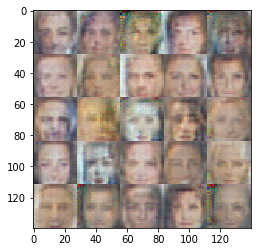

Epoch 1 Discriminator Loss: 1.465 Generator Loss: 0.660
Epoch 1 Discriminator Loss: 1.344 Generator Loss: 0.677
Epoch 1 Discriminator Loss: 1.344 Generator Loss: 0.692
Epoch 1 Discriminator Loss: 1.329 Generator Loss: 0.747
Epoch 1 Discriminator Loss: 1.404 Generator Loss: 0.834
Epoch 1 Discriminator Loss: 1.270 Generator Loss: 0.660
Epoch 1 Discriminator Loss: 1.315 Generator Loss: 0.937
Epoch 1 Discriminator Loss: 1.464 Generator Loss: 0.746
Epoch 1 Discriminator Loss: 1.409 Generator Loss: 0.702
Epoch 1 Discriminator Loss: 1.310 Generator Loss: 0.765


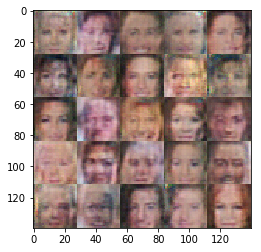

Epoch 1 Discriminator Loss: 1.348 Generator Loss: 0.742
Epoch 1 Discriminator Loss: 1.406 Generator Loss: 0.675
Epoch 1 Discriminator Loss: 1.442 Generator Loss: 0.830
Epoch 1 Discriminator Loss: 1.370 Generator Loss: 0.650
Epoch 1 Discriminator Loss: 1.502 Generator Loss: 0.893
Epoch 1 Discriminator Loss: 1.457 Generator Loss: 0.832
Epoch 1 Discriminator Loss: 1.371 Generator Loss: 0.853
Epoch 1 Discriminator Loss: 1.383 Generator Loss: 0.715
Epoch 1 Discriminator Loss: 1.423 Generator Loss: 0.931
Epoch 1 Discriminator Loss: 1.322 Generator Loss: 0.756


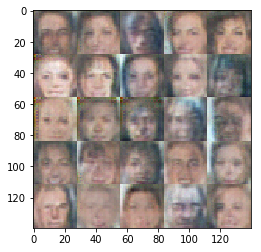

Epoch 1 Discriminator Loss: 1.380 Generator Loss: 0.521
Epoch 1 Discriminator Loss: 1.391 Generator Loss: 0.789
Epoch 1 Discriminator Loss: 1.343 Generator Loss: 0.679
Epoch 1 Discriminator Loss: 1.268 Generator Loss: 0.660
Epoch 1 Discriminator Loss: 1.347 Generator Loss: 0.675
Epoch 1 Discriminator Loss: 1.406 Generator Loss: 0.811
Epoch 1 Discriminator Loss: 1.402 Generator Loss: 0.620
Epoch 1 Discriminator Loss: 1.375 Generator Loss: 0.811
Epoch 1 Discriminator Loss: 0.706 Generator Loss: 1.156
Epoch 1 Discriminator Loss: 1.377 Generator Loss: 0.874


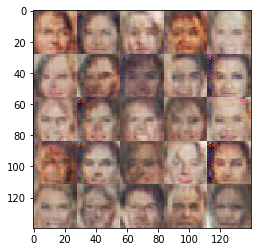

Epoch 1 Discriminator Loss: 1.423 Generator Loss: 0.813
Epoch 1 Discriminator Loss: 1.406 Generator Loss: 0.817
Epoch 1 Discriminator Loss: 1.419 Generator Loss: 0.780
Epoch 1 Discriminator Loss: 1.337 Generator Loss: 0.609
Epoch 1 Discriminator Loss: 1.390 Generator Loss: 0.674
Epoch 1 Discriminator Loss: 1.306 Generator Loss: 0.651
Epoch 1 Discriminator Loss: 1.092 Generator Loss: 0.691
Epoch 1 Discriminator Loss: 1.015 Generator Loss: 1.468
Epoch 1 Discriminator Loss: 0.919 Generator Loss: 1.017
Epoch 1 Discriminator Loss: 0.269 Generator Loss: 2.543


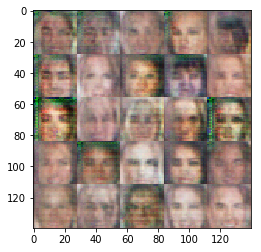

Epoch 1 Discriminator Loss: 1.805 Generator Loss: 0.843
Epoch 1 Discriminator Loss: 1.333 Generator Loss: 0.839
Epoch 1 Discriminator Loss: 1.493 Generator Loss: 0.722
Epoch 1 Discriminator Loss: 1.347 Generator Loss: 0.696
Epoch 1 Discriminator Loss: 1.294 Generator Loss: 0.801
Epoch 1 Discriminator Loss: 1.375 Generator Loss: 0.599
Epoch 1 Discriminator Loss: 1.336 Generator Loss: 0.820
Epoch 1 Discriminator Loss: 1.384 Generator Loss: 0.801
Epoch 1 Discriminator Loss: 1.294 Generator Loss: 0.819
Epoch 1 Discriminator Loss: 1.424 Generator Loss: 0.796


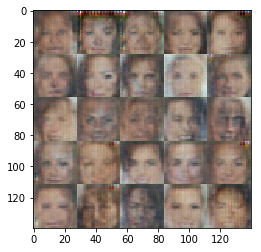

Epoch 1 Discriminator Loss: 1.383 Generator Loss: 0.702
Epoch 1 Discriminator Loss: 1.338 Generator Loss: 0.792
Epoch 1 Discriminator Loss: 1.380 Generator Loss: 0.682
Epoch 1 Discriminator Loss: 1.368 Generator Loss: 0.885
Epoch 1 Discriminator Loss: 1.371 Generator Loss: 0.791
Epoch 1 Discriminator Loss: 1.393 Generator Loss: 0.723


In [16]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.